# Photometric Color correction

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS


## Import

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import pandas as pd

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from scipy import interpolate

In [5]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [7]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
import warnings
warnings.filterwarnings("ignore")

## Configuration

In [9]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"
path_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline") 

In [10]:
atm_std_filename = "atmos_std.dat"

In [11]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

In [12]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

## Initialisation

In [13]:
df_std=pd.DataFrame()

In [14]:
df_std["wl"] = WL

### Standard atmosphere

In [15]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [16]:
arr= np.loadtxt(fullfilename)

In [17]:
#f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value=1)

In [18]:
atm_std=f(WL)

In [19]:
df_std["atm"] = atm_std

### Total filters

In [20]:
FILTERWL = np.zeros((NFILT,4))
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    throughput1=ff(WL)
    throughput2=throughput1/atm_std
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    indexes=np.where(throughput2>0.05)[0]
    #left border of filter
    FILTERWL[index,0]=WL[indexes.min()] 
    # right border of the filter
    FILTERWL[index,1]=WL[indexes.max()] 
    # width of the filter
    FILTERWL[index,3]=WL[indexes.max()]-WL[indexes.min()]  
    #lambda_b
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

In [21]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

Text(0.5, 1.0, 'Instrument transmission')

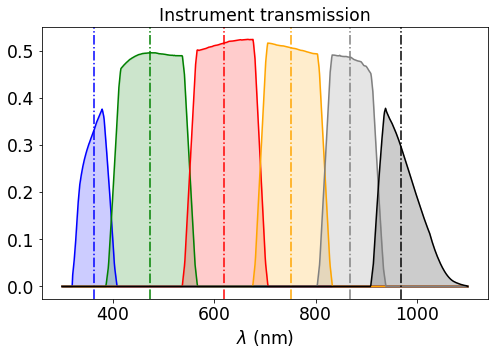

In [22]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Text(0.5, 1.0, 'Instrument and atmosphere transmission')

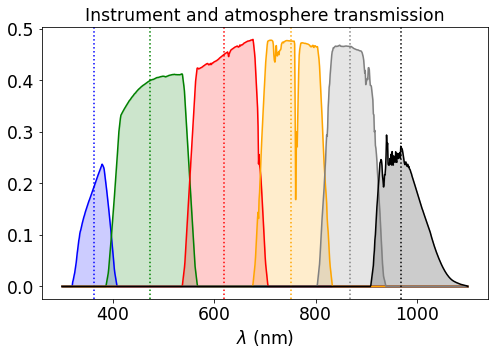

In [23]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="tot_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument and atmosphere transmission")

## Functions

In [24]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

In [25]:
def fII1(wl,s,wlb):
    return np.trapz(s*(wl-wlb)/wl,wl)

In [26]:
def fII2(wl,s,wlb):
    return np.trapz(s*(wl-wlb)**2/wl,wl)

In [27]:
def fII10(wl,s,wlb):
    return fII1(wl,s,wlb)/fII0(wl,s)

In [28]:
def fII20(wl,s,wlb):
    return fII2(wl,s,wlb)/fII0(wl,s)

In [29]:
def CalculateIIntegrals(df_S,wlb):
    """
    """
    II0 = np.zeros(NFILT)
    II1 = np.zeros(NFILT)
    II2 = np.zeros(NFILT)
    II10 = np.zeros(NFILT)
    II20 = np.zeros(NFILT)
    
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S=df_S[tag].values
        II0[index] = fII0(wl,S)
        II1[index] = fII1(wl,S,wlb[index])
        II2[index] = fII2(wl,S,wlb[index])
        II10[index] = fII10(wl,S,wlb[index])
        II20[index] = fII20(wl,S,wlb[index])
        
    df_II = pd.DataFrame()
    df_II["II0"]=II0
    df_II["II1"]=II1
    df_II["II2"]=II2
    df_II["II10"]=II10
    df_II["II20"]=II20    
    return df_II
    

## Calculate Integrals for Standard atmosphere

In [30]:
df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [31]:
df_IIstd 

,II0,II1,II2,II10,II20
0,0.033338,0.079194,12.612354,2.375463,378.312338
1,0.121926,0.305935,230.105550,2.509184,1887.257382
2,0.100710,0.096977,167.700718,0.962933,1665.181331
3,0.077127,0.025279,109.332320,0.327765,1417.570239
4,0.053724,-0.024968,50.296178,-0.464738,936.189562
5,0.025932,0.089871,32.480106,3.465616,1252.500277


## Creation of df_obs and set Airmass variation effect

- create a dataframe df_obs containing all info related to observed atmosphere

In [32]:
all_am = np.linspace(1,2.5,16)
NAM=len(all_am)
pwv= 3
aer= 0.04
oz = 300

In [33]:
all_df_obs = []


for index,am in enumerate(all_am):
    path,thefile = libsimulateVisible.ProcessSimulationaer(am,pwv,oz,aer,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data = np.loadtxt(os.path.join(path,thefile))
    f = interpolate.interp1d(x=data[:,0], y=data[:,1],fill_value="extrapolate")
    atm=f(WL)
    
    
    df_obs=pd.DataFrame()
    df_obs["wl"] = WL
    df_obs["atm"] = atm
    
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]
    
        df_obs[tag1]= df_std[tag2].values*atm
        df_obs[tag2]= df_std[tag2].values
    
    all_df_obs.append(df_obs)
    

******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from  0.500000 to 0.500055
******* WARNING >>>>>> 
 SETDIS--beam angle=computational angle;
 ******* changing cosine of solar zenith angle, umu0, from 

Text(0.5, 1.0, 'standard and observed transmission')

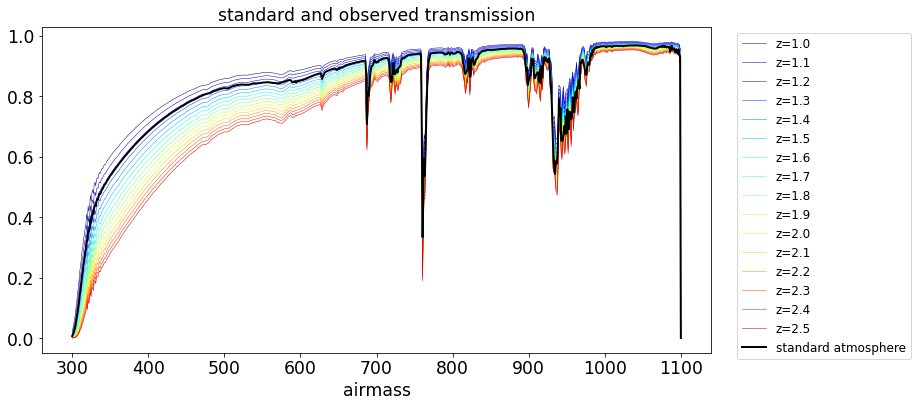

In [37]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)

fig, axs = plt.subplots(1,1,figsize=(12,6))

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    am = all_am[index]
    label = f"z={am:.1f}"
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("airmass")
axs.set_title("standard and observed transmission")

# Integrals

# Calculate Integrals for observed atmosphere

In [38]:
all_df_IIobs = []
for idx,the_df_obs in enumerate(all_df_obs):
    the_df_IIobs = CalculateIIntegrals(the_df_obs,FILTERWL[:,2])
    all_df_IIobs.append(the_df_IIobs) 
    
    print(f"======== obs = {idx} =======")
    print(the_df_IIobs)

======== obs = 0 =======
        II0       II1         II2      II10         II20
0  0.036819  0.071688   13.987404  1.947047   379.897660
1  0.127469  0.273772  241.272659  2.147756  1892.799011
2  0.104073  0.085577  173.339472  0.822277  1665.557890
3  0.079450  0.016995  112.570411  0.213905  1416.876011
4  0.055218 -0.014686   52.367606 -0.265966   948.378907
5  0.027682  0.062420   33.834689  2.254898  1222.266471
======== obs = 1 =======
        II0       II1         II2      II10         II20
0  0.035203  0.075163   13.352432  2.135128   379.297229
1  0.125070  0.295110  236.574612  2.359562  1891.539798
2  0.102987  0.093622  171.562510  0.909071  1665.866759
3  0.078947  0.019053  111.902546  0.241339  1417.441093
4  0.054971 -0.015666   52.061421 -0.284987   947.068585
5  0.027449  0.066187   33.644012  2.411273  1225.690260
======== obs = 2 =======
        II0       II1         II2      II10         II20
0  0.033662  0.078162   12.749179  2.322004   378.746080
1  0.122719  

# Study of Integrals

In [39]:
df_IIstd 

,II0,II1,II2,II10,II20
0,0.033338,0.079194,12.612354,2.375463,378.312338
1,0.121926,0.305935,230.105550,2.509184,1887.257382
2,0.100710,0.096977,167.700718,0.962933,1665.181331
3,0.077127,0.025279,109.332320,0.327765,1417.570239
4,0.053724,-0.024968,50.296178,-0.464738,936.189562
5,0.025932,0.089871,32.480106,3.465616,1252.500277


## Calculate II differences

In [40]:
all_II_diff = []
for idx,z in enumerate(all_am):
    II_diff = all_df_IIobs[idx]-df_IIstd  
    all_II_diff.append(II_diff) 

In [41]:
all_II_div = []
for idx,z in enumerate(all_am):
    II_div = all_df_IIobs[idx]/df_IIstd  
    all_II_div.append(II_div) 

In [42]:
all_II_diff[15]

,II0,II1,II2,II10,II20
0,-0.014369,0.008873,-5.484328,2.266980,-2.558864
1,-0.025810,0.200090,-49.568224,2.755552,-8.927310
2,-0.011717,0.093824,-18.958861,1.181062,6.204780
3,-0.004546,0.022120,-6.189474,0.325295,3.519251
4,-0.001966,0.000097,-2.110433,-0.015788,-5.211852
5,-0.001109,0.014429,-1.063693,0.736189,13.128754


In [43]:
all_II_diff[7].iloc[5]["II0"]

0.000271504579876701

In [44]:
#filter_tagnames = ["u","g","r","i","z","y"]
#filter_color = ["b","g","r","orange","grey","k"]
#NFILT=len(filter_filenames)

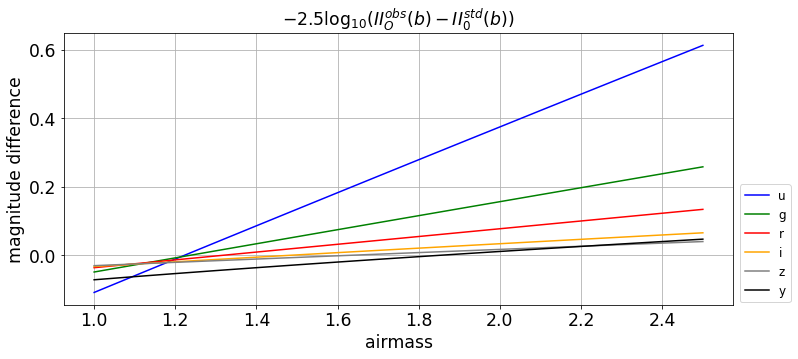

In [45]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_div_mag[idx]=-2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
    ax.plot(all_am,the_div_mag,color=filter_color[ifilt],label=filter_tagnames[ifilt])
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude difference")
ax.set_title("$-2.5 \log_{10} (II_O^{obs}(b)-II_0^{std}(b))$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

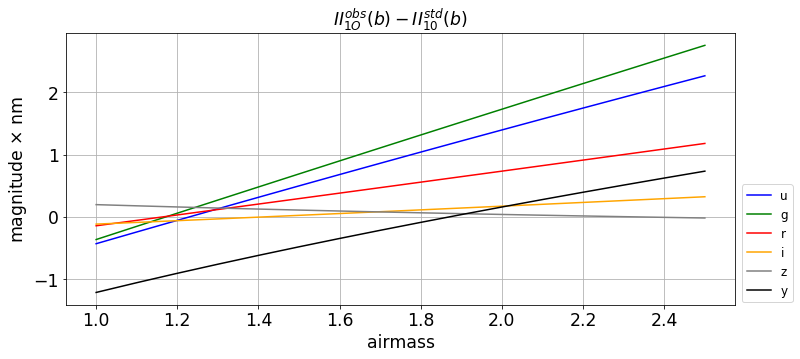

In [66]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II10"]
    ax.plot(all_am,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt])
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude $\\times$ nm")
ax.set_title("$II_{1O}^{obs}(b)-II_{10}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

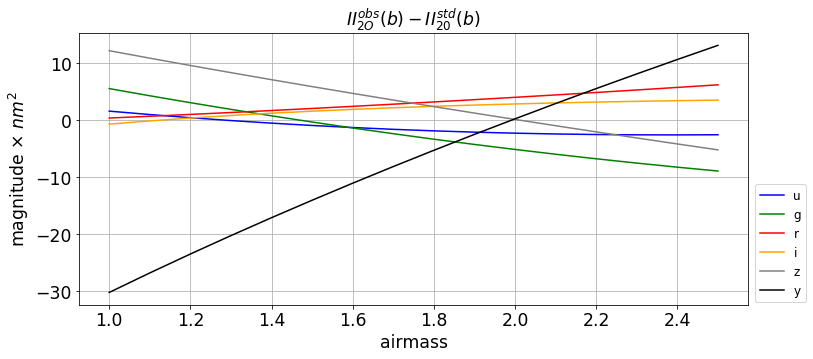

In [65]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NAM)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_am):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II20"]
    ax.plot(all_am,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt])
ax.set_xlabel("airmass")
ax.set_ylabel("magnitude $\\times \,\, nm^2$")
ax.set_title("$II_{2O}^{obs}(b)-II_{20}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

# SED

In [48]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

seds = {}
sedsfnu = {}
sedtypeslists = {}

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        

In [49]:
#list(seds.keys())

In [50]:
#sedtypeslists

In [51]:
NSED = len(list(seds.keys()))

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [52]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
z=1.5
seds['quasar'].redshiftSED(z)

Text(0, 0.5, 'Wavelength * Flambda')

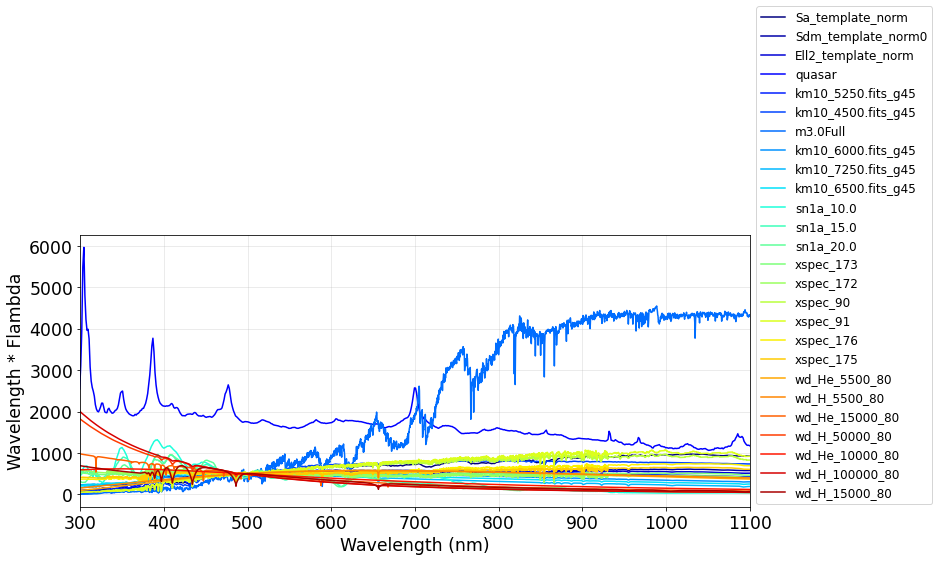

In [53]:
# Plot the seds
plt.figure(figsize=(12,5))
for idx,n in enumerate(seds):
    plt.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, color=all_colors[idx],label=n)
plt.legend(loc=(1.01, 0.01))
plt.xlim(300, 1100)
plt.grid(alpha=0.3)
plt.xlabel('Wavelength (nm)')
plt.ylabel("Wavelength * Flambda")

In [54]:
sedtypeslists["galaxies"]

['Sa_template_norm', 'Sdm_template_norm0', 'Ell2_template_norm']

Text(0.5, 0.95, 'SED $\\lambda F_\\lambda$')

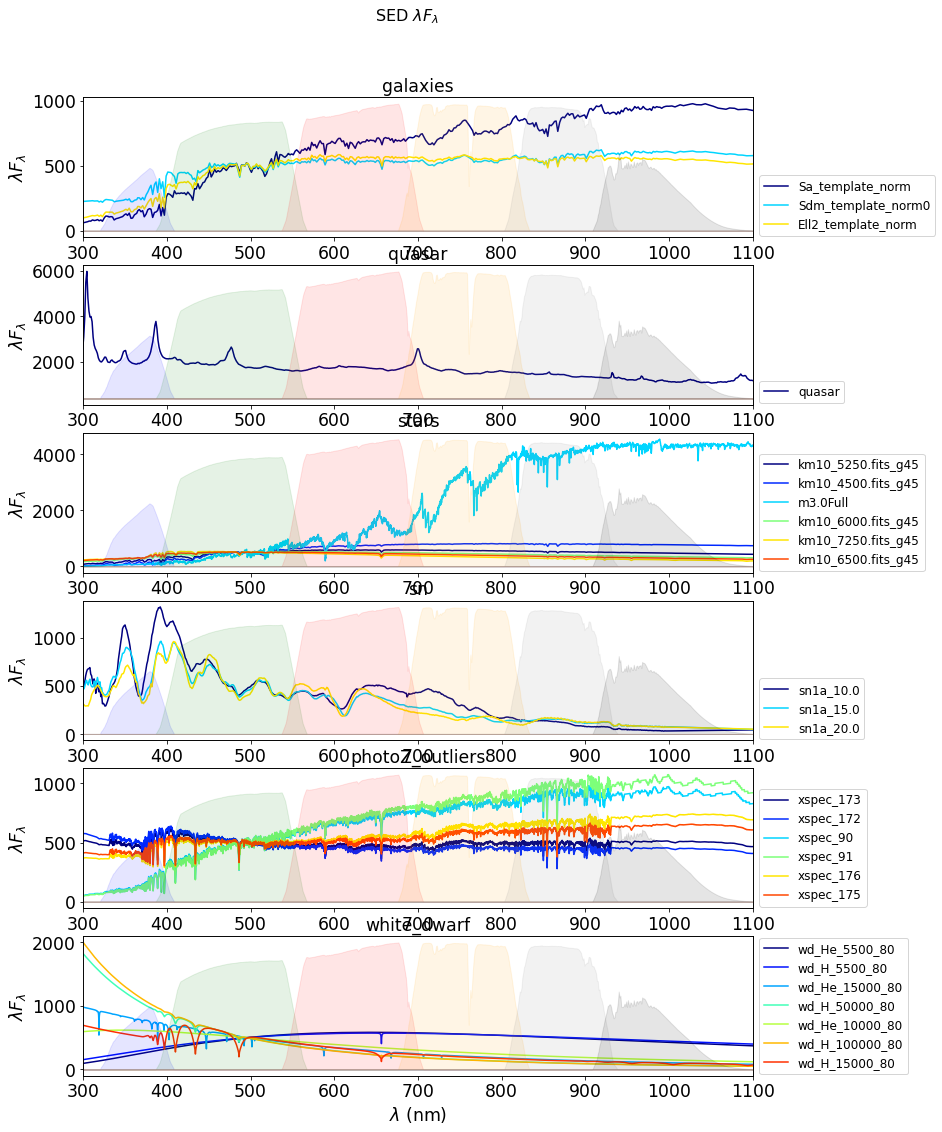

In [55]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        axs[idx].plot(seds[name].wavelen, seds[name].flambda * seds[name].wavelen, color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$\lambda F_\lambda$")
    
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
#plt.tight_layout()
plt.suptitle("SED $\\lambda F_\\lambda$",fontsize=16,y=.95)

Text(0.5, 1.01, 'SED $F_\\nu$')

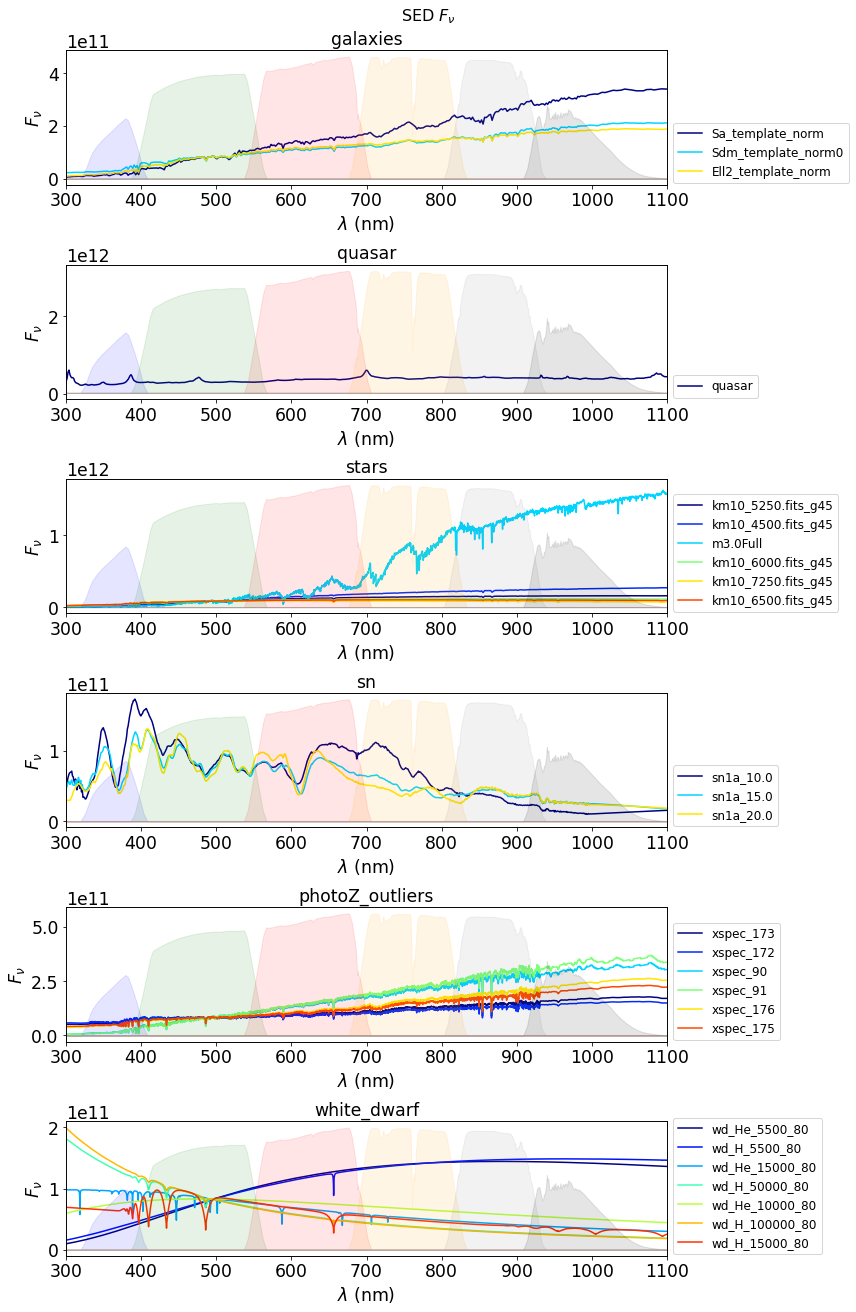

In [56]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        axs[idx].plot(wavel, fnu , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^\\prime_\\nu$')

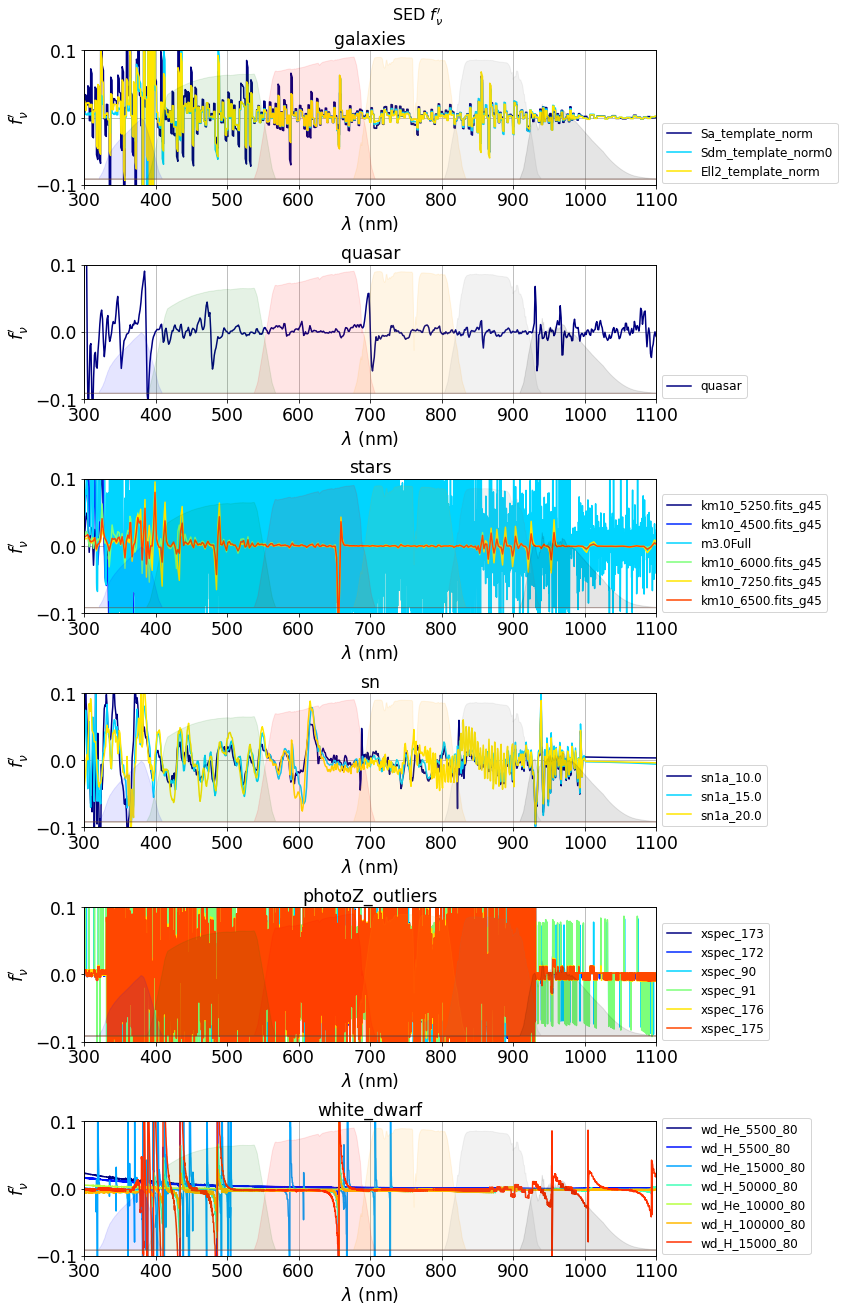

In [57]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fratio = fnup/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(-.1,.1)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^\prime_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^{\\prime\\prime}_\\nu$')

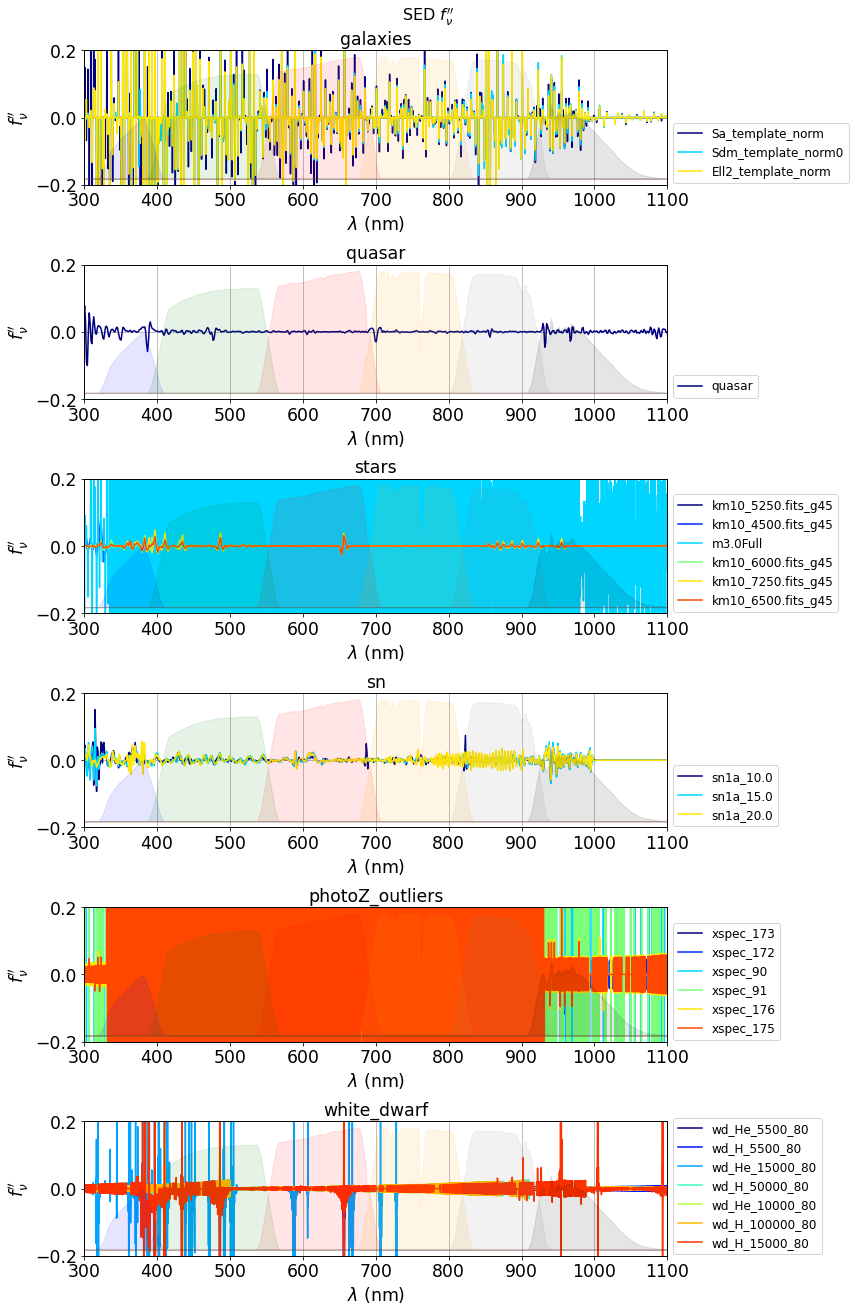

In [58]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(-.2,.2)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

# Filtering the SED

In [59]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


In [60]:
span=150

Text(0.5, 1.01, 'Filtered SED $F_\\nu$')

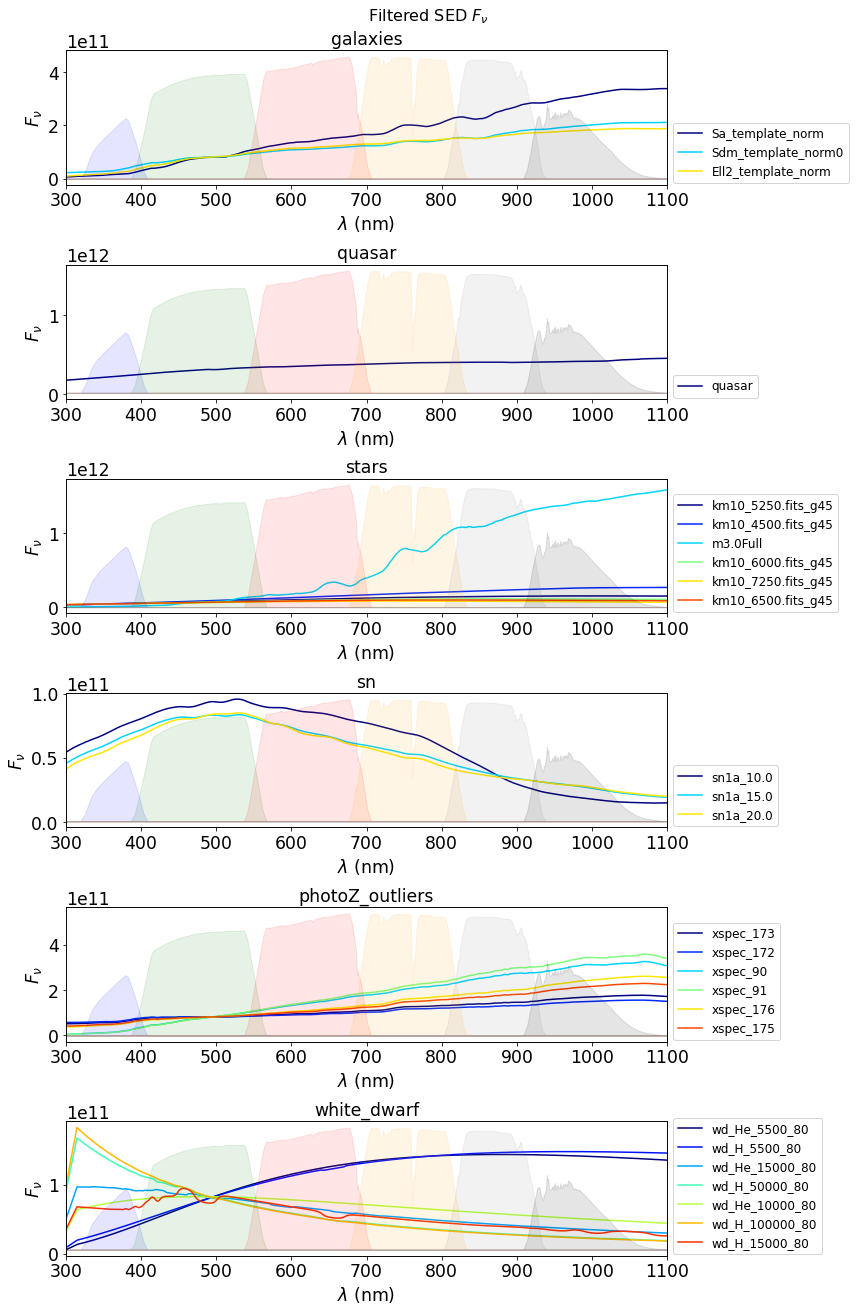

In [61]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        
        axs[idx].plot(wavel, fnu_filtered , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("Filtered SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'Filtered SED $f^\\prime_\\nu$')

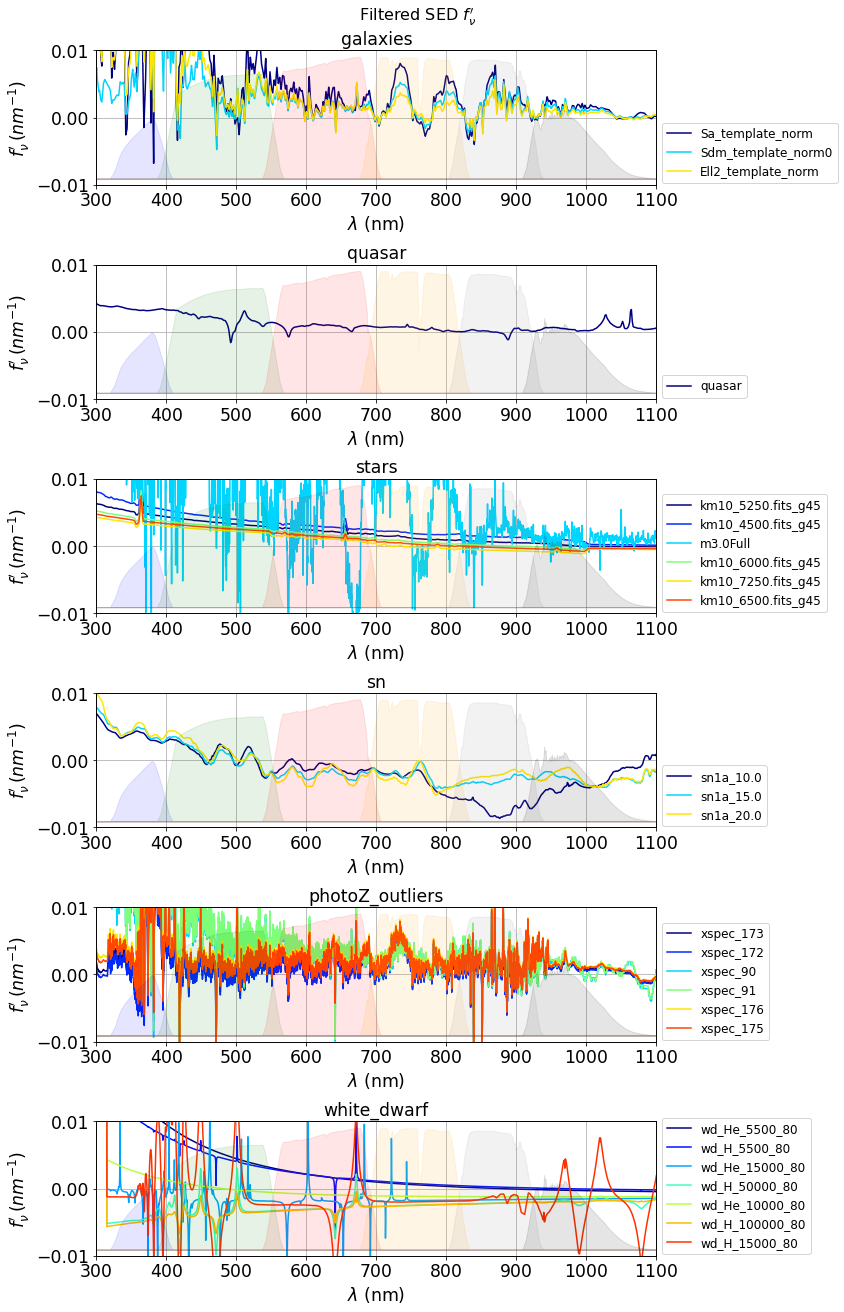

In [62]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fratio = fnup/fnu_filtered
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(-.01,.01)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu \, (nm^{-1})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^\prime_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'Filtered SED $f^{\\prime\\prime}_\\nu$')

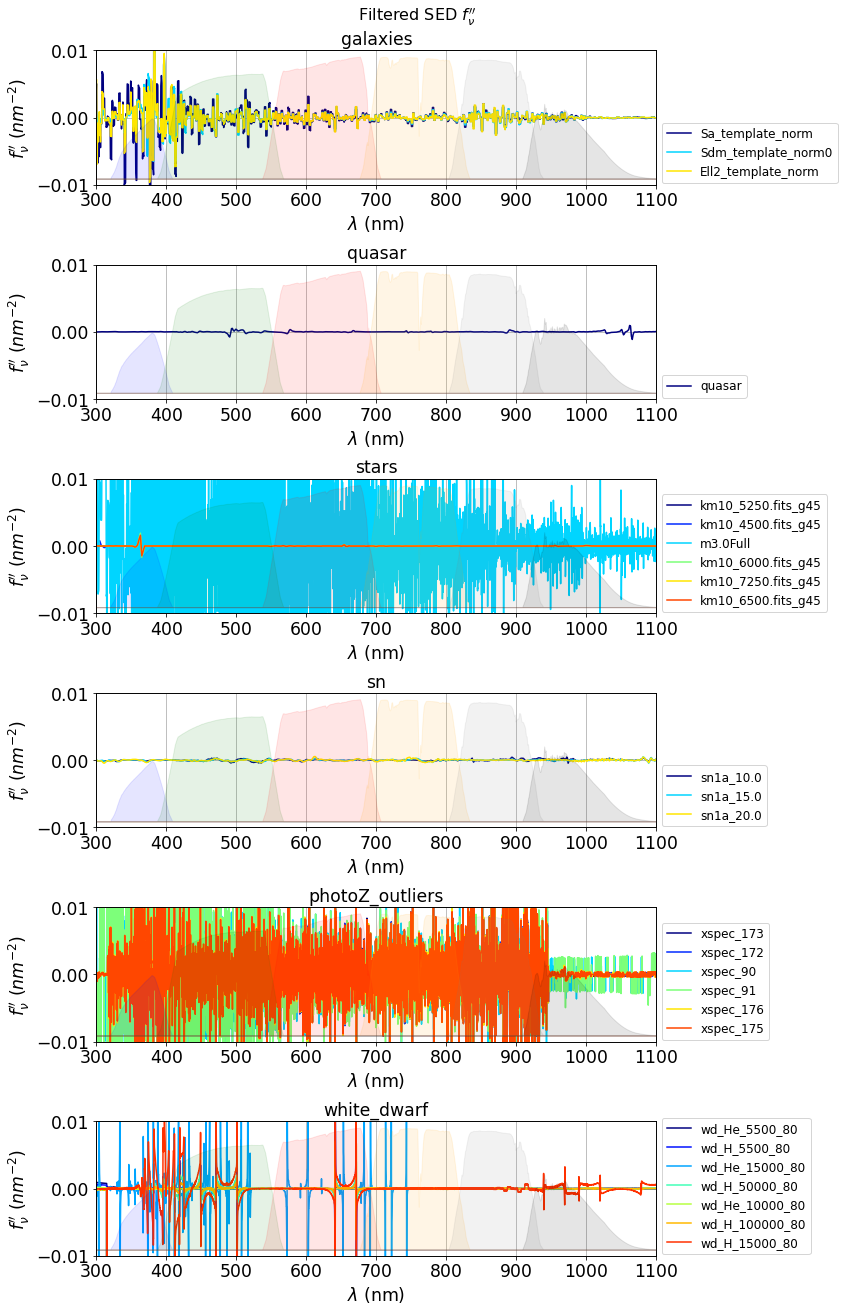

In [63]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(-.01,.01)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu \,\, (nm^{-2})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)